[MoviePy] >>>> Building video output_videos/white.mp4
[MoviePy] Writing video output_videos/white.mp4


100%|█████████▉| 221/222 [00:04<00:00, 54.22it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/white.mp4 

CPU times: user 3.04 s, sys: 1.24 s, total: 4.28 s
Wall time: 4.63 s
[MoviePy] >>>> Building video output_videos/yellow.mp4
[MoviePy] Writing video output_videos/yellow.mp4


100%|█████████▉| 681/682 [00:16<00:00, 41.21it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/yellow.mp4 

CPU times: user 11.3 s, sys: 4.15 s, total: 15.4 s
Wall time: 17.2 s


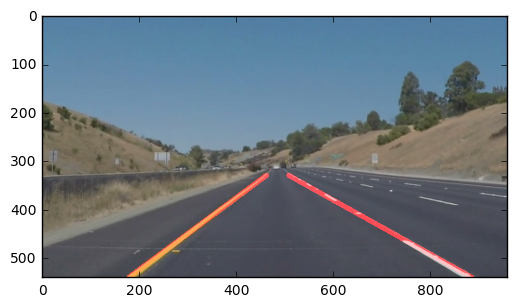

In [66]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
%matplotlib inline
import math
import collections as clx

### CONFIGURATION ###
gaussian_kernel      = 3
canny_low_threshold  = 50
canny_high_threshold = 150
top_mask_y           = 330
bottom_mask_y        = 540
vertices             = np.array([[[430,top_mask_y], [530,top_mask_y], [900,bottom_mask_y], [110,bottom_mask_y] ]], np.int32)  # POINT OF INTEREST
hough_rho            = 2
hough_theta          = np.pi/180    # 1 degree
hough_threshold      = 20           # meaning at least 15 points in image space need to be associated with each line segment. 
hough_min_line_len   = 35
hough_max_line_gap   = 20 
cached_lines_length  = 20
cached_left_lines    = clx.deque(maxlen=cached_lines_length)
cached_right_lines   = clx.deque(maxlen=cached_lines_length)
### CONFIGURATION ###

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):

    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):

    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

# Show region defined by vertices polygon
def region_of_interest(img, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

# average/extrapolage detected line segments 
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

# img=Canny output, returns image with drawn hough lines
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, color=[255,0,0]):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines,color)
    return line_img

# img=hough_lines() output
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):

    return cv2.addWeighted(initial_img, α, img, β, λ)

def slope (line):
    x1, y1, x2, y2 = line
    return ((y2-y1)/(x2-x1))

def intercept(line):
    x1, y1, x2, y2 = line
    m = slope(line)
    b = y2 - ( m * x2 )
    return b 

def extrapolate_line(line,top_y,bottom_y):
    m = slope(line)
    b = intercept(line)
    top_x    = int((top_y - b) / m)
    bottom_x = int((bottom_y - b) / m)
    return [[ top_x, top_y, bottom_x, bottom_y ]]

def render_image(image, debug=False, cache=False):

    gray        = grayscale(image)
    blur_gray   = gaussian_blur(gray,gaussian_kernel)
    edges       = cv2.Canny(blur_gray, canny_low_threshold, canny_high_threshold)
    edges       = region_of_interest( edges, vertices )
    lines       = cv2.HoughLinesP(edges, hough_rho, hough_theta, hough_threshold, np.array([]), hough_min_line_len, hough_max_line_gap)
    left_lines  = []
    right_lines = []

    for line in lines:
        for x1,y1,x2,y2 in line:
            # SEPARATE BETWEEN LEFT AND RIGHT LINES
            # WARNING: Python 2.x return int while 3.x return float 0.x, (y2-y1)/(x2-x1) < 0 won't work. Use <= 0 instead
            if ( (y2-y1)/(x2-x1) < 0 ):
                # print('LEFT')
                if math.fabs((y2-y1)/(x2-x1)) > 0.2: # Cancel out horizontal lines
                    left_lines.append(line)
            else:
                # print('RIGHT')
                if math.fabs((y2-y1)/(x2-x1)) > 0.2: # Cancel out horizontal lines
                    right_lines.append(line)

    # CALCULATE AVERAGE
    left_mean    = np.mean(left_lines,0)
    right_mean   = np.mean(right_lines,0)
    left_mean    = list(map(int, *left_mean))
    right_mean   = list(map(int, *right_mean))
    # EXTRAPOLATE MAIN LINES
    left_x_line  = extrapolate_line(left_mean,top_mask_y,bottom_mask_y)
    right_x_line = extrapolate_line(right_mean,top_mask_y,bottom_mask_y)

    # AVERAGE CACHED LINES
    if cache == True:
        global cached_left_lines
        global cached_right_lines
        cached_left_lines.append(left_x_line)
        cached_right_lines.append(right_x_line)
        cll_mean = np.mean(list(cached_left_lines),0)
        crl_mean = np.mean(list(cached_right_lines),0)
        cll_mean = [list(map(int, *cll_mean))]
        crl_mean = [list(map(int, *crl_mean))]
        left_x_line = cll_mean
        right_x_line = crl_mean
    # AVERAGE CACHED LINES
    
    line_img = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, [left_x_line, right_x_line], [255, 0, 0], 10)
    comp = weighted_img(line_img, image, α=0.8, β=1., λ=0.)
    if debug == True:
        blank = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
        draw_lines(blank, lines, [0, 255, 0], 2)
        comp = weighted_img(comp, blank, α=0.8, β=1., λ=0.)
    return comp

# TODO: Build your pipeline that will draw lane lines on the test_images then save them to the test_images directory.
import os

# VIDEO | Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_image(image):
    result = render_image(image, cache=True) 
    return result

# RENDER TEST IMAGES
imageList = os.listdir('test_images/')
for image in imageList:
    render = render_image( mpimg.imread('test_images/' + image ), debug=False )
    plt.imshow( render )
    plt.savefig( 'output_images/' + image )
    
# RENDER WHITE LINE VIDEO
white_output = 'output_videos/white.mp4'
clip2 = VideoFileClip('solidWhiteRight.mp4')
white_clip = clip2.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

# CLEAR LINES CACHE BEFORE PROCEEDING TO NEXT VIDEO
cached_left_lines.clear()
cached_right_lines.clear()

# RENDER YELLOW LINE VIDEO
yellow_output = 'output_videos/yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

HTML("""
<video width="960" height="540" controls><source src="{0}"></video>
""".format(yellow_output))